In [1]:
import pandas as pd
import pandas as pd
import copy
import random as rd
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt 
import math

In [2]:
#!/ usr/bin/python
# -*- coding:utf-8 -*-
import matplotlib.pyplot as plt
import math


def dcm2dgr(a):#大地坐标经纬度小数表示转度数表示
    x = int(a)
    tmpy = a-x
    y = int(tmpy*60)
    tmpz = tmpy*60 - y
    z = tmpz*60
    return (x,y,z)
def dgr2dcm(a):#大地坐标经纬度度数表示转小数表示
    x,y,z = a
    return x+y/60+z/3600


def XY2LatLon(X, Y, L0=42+39):#+39变成6度投影

    iPI = 0.0174532925199433
    a = 6378137.0
    f= 0.00335281006247
    ZoneWide = 3 #按3度带进行投影

    ProjNo = int(X / 1000000)
    L0 = L0 * iPI
    X0 = ProjNo * 1000000 + 500000
    Y0 = 0
    xval = X - X0
    yval = Y - Y0

    e2 = 2 * f - f * f #第一偏心率平方
    e1 = (1.0 - math.sqrt(1 - e2)) / (1.0 + math.sqrt(1 - e2))
    ee = e2 / (1 - e2) #第二偏心率平方

    M = yval
    u = M / (a * (1 - e2 / 4 - 3 * e2 * e2 / 64 - 5 * e2 * e2 * e2 / 256))

    fai = u \
          + (3 * e1 / 2 - 27 * e1 * e1 * e1 / 32) * math.sin(2 * u) \
          + (21 * e1 * e1 / 16 - 55 * e1 * e1 * e1 * e1 / 32) * math.sin(4 * u) \
          + (151 * e1 * e1 * e1 / 96) * math.sin(6 * u)\
          + (1097 * e1 * e1 * e1 * e1 / 512) * math.sin(8 * u)
    C = ee * math.cos(fai) * math.cos(fai)
    T = math.tan(fai) * math.tan(fai)
    NN = a / math.sqrt(1.0 - e2 * math.sin(fai) * math.sin(fai))
    R = a * (1 - e2) / math.sqrt(
        (1 - e2 * math.sin(fai) * math.sin(fai)) * (1 - e2 * math.sin(fai) * math.sin(fai)) * (1 - e2 * math.sin(fai) * math.sin(fai)))
    D = xval / NN

    #计算经纬度（弧度单位的经纬度）
    longitude1 = L0 + (D - (1 + 2 * T + C) * D * D * D / 6 + (
    5 - 2 * C + 28 * T - 3 * C * C + 8 * ee + 24 * T * T) * D * D * D * D * D / 120) / math.cos(fai)
    latitude1 = fai - (NN * math.tan(fai) / R) * (
    D * D / 2 - (5 + 3 * T + 10 * C - 4 * C * C - 9 * ee) * D * D * D * D / 24 + (
    61 + 90 * T + 298 * C + 45 * T * T - 256 * ee - 3 * C * C) * D * D * D * D * D * D / 720)

    #换换为deg
    longitude = longitude1 / iPI
    latitude = latitude1 / iPI

    return latitude, longitude


# LatLon2XY(40.07837722329, 116.23514827596)
# XY2LatLon(434760.7611718801, 4438512.040474475, 117.0)

x = 4311109.5
y = 14749903.4

tmp = XY2LatLon(y,x)
tmp

(38.89784353649511, 83.88044409462027)

In [3]:
# 计算地表热流和地面温度

pthBaseInfo = r'D:\workplace\geoproject\pictureproject\data\material\温度\基本信息.xlsx'
dataBaseInfo= pd.read_excel(pthBaseInfo)

dataBaseInfo
def caldis(pos1, pos2):
    x = pos1[0]-pos2[0]
    y = pos1[1]-pos2[1]
    return math.sqrt( x*x+y*y )
    
def getLineNearest(line, tarpos):
    dis = float('inf')
    tar = ''
    tarline = ''

    for j in line:
        tmpdis = caldis( j, tarpos)
        if tmpdis< dis:
            dis = tmpdis
            tar = j 
    return tar 

def getNearest(line, tarpos):
    dis = float('inf')
    tar = ''
    tarline = ''

    for i in line.keys():
        j = getLineNearest( line[i], tarpos)
        tmpdis = caldis( j, tarpos)
        if tmpdis< dis:
            dis = tmpdis
            tar = j 
            tarline = i
    # print(dis)
    return tarline, tar

def judcircle(p0, p1, aline):
    # print(aline)
    # print(len(aline))

    dis = float('inf')
    tmp = ''
    for px in aline:
        # print(px)
        p0px = (px[0]-p0[0], px[1]-p0[1])
        p0p1 = (p1[0]-p0[0], p1[1]-p0[1])
        x1 = p0px[0]
        y1 = p0px[1]
        x2 = p0p1[0]
        y2 = p0p1[1]
        cosx = (x1*x2+y1*y2)/(math.sqrt(x1*x1+y1*y1)*math.sqrt(x2*x2+y2*y2)) 
        # print(cosx, (x1*x1+y1*y1),(x2*x2+y2*y2) )
        if (x1*x1+y1*y1)< dis:
            dis = (x1*x1+y1*y1)
            tmp = (cosx, (x1*x1+y1*y1), (x2*x2+y2*y2))
        if (abs(cosx-1) <0.06)  and ( (x1*x1+y1*y1)<(x2*x2+y2*y2) ):
            return True
    return False


def calval(tarpos, line):
    tarline, tar = getNearest(line, tarpos)
    tar1 = getLineNearest(line[tarline-2], tarpos )
    tar2 = getLineNearest(line[tarline+2], tarpos )

    tar3=[]
    if not judcircle(tarpos, tar1, line[tarline] ):
        tar3.append( [-2, tar1])
    if not judcircle(tarpos, tar2, line[tarline] ):
        tar3.append( [2, tar2])
    if len(tar3) == 2:
        print('false')

    tar3 = tar3[0]

    dis1 = caldis( tarpos, tar)
    dis2 = caldis( tarpos, tar3[1] )

    # plt.figure(figsize=(20,20))
    # plt.scatter( tarpos[1],tarpos[0], marker='*')
    # plt.scatter( tar[1], tar[0], marker='o')
    # plt.scatter(  tar3[1][1], tar3[1][0], marker='^')
    # plt.show()
    # print( tarline)
    tarposval = tarline + tar3[0]*(dis1/(dis2+dis1) )
    return round(tarposval, 2) 


pthBaseInfo = r'D:\workplace\geoproject\pictureproject\data\material\温度\基本信息.xlsx'
dataBaseInfo= pd.read_excel(pthBaseInfo)
pthhf = r'D:\workplace\geoproject\pictureproject\data\material\热流图\hf.txt'

line = {' ':[]}
with open(pthhf) as f:
    for i in f.readlines():
        tmpi = i.split(',')
        if len(tmpi) != 3:
            continue
        if len( tmpi[0] ) ==0:
            X = float( tmpi[2].split('\n')[0] )
            Y = float( tmpi[1] )
            tar = XY2LatLon(Y,X)
            line[' '].append(  (round(tar[0],6) , round(tar[1], 6)))
        else:
            X = float( tmpi[2].split('\n')[0] )
            Y = float( tmpi[1] )    
            num = int( tmpi[0] )   
            if num not in line.keys():
                line[num] = []
            tar = XY2LatLon(Y,X)
            line[num].append(  (round(tar[0],6) , round(tar[1], 6)))



htflow = []
tmprt = []
for index, row in dataBaseInfo.iterrows():
    posWell = row['井位']
    tarX = row['X']
    tarY = row['Y']

    tarpos = XY2LatLon( tarY, tarX)
    tarpos = (round(tarpos[0],6), round(tarpos[1], 6))


    tarhf = calval( tarpos, line)
    print(posWell, tarpos, tarhf )
    htflow.append( tarhf )

    pthStaticTmprt = r'D:\workplace\geoproject\pictureproject\data\material\温度\xlsx-静温\静温-%s.xlsx' % posWell
    staticTmprt = pd.read_excel( pthStaticTmprt )
    tartmprt = staticTmprt.iloc[0]['温度']

    print( staticTmprt.iloc[0]['温度'] )
    tmprt.append( tartmprt )

dataBaseInfo['地表热流'] = htflow
dataBaseInfo['地表温度'] = tmprt 


dataBaseInfo.to_excel(pthBaseInfo)

,Unnamed: 0,Unnamed: 0.1,井位,X,Y,补心海拔,补心高,地表热流,地表温度
0,0,0,轮探1井,4593859.900,1.474916e+07,947.250,12.0,38.17,20.270
1,1,1,中探1井,4402170.004,1.456863e+07,1071.971,10.5,42.50,34.885
2,2,2,中深1井,4311109.500,1.474990e+07,1148.530,10.5,51.29,10.210
3,3,3,玛5井,4285834.400,1.444556e+07,1352.500,6.7,51.05,30.170
4,4,4,满深1井,4466165.400,1.469745e+07,976.790,13.7,35.65,34.270


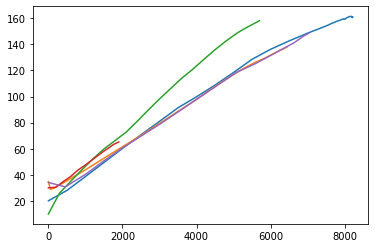

In [6]:

# 显示静温

pthBaseInfo = r'D:\workplace\geoproject\pictureproject\data\material\温度\基本信息.xlsx'
dataBaseInfo= pd.read_excel(pthBaseInfo)

allTmprt = {}
for index, row in dataBaseInfo.iterrows():
    posWell = row['井位']
    hf = row['地表热流']
    gt = row['地表温度']

    pthStaticTmprt = r'D:\workplace\geoproject\pictureproject\data\material\温度\xlsx-静温\静温-%s.xlsx' % posWell
    staticTmprt = pd.read_excel( pthStaticTmprt )

    allTmprt[posWell] = staticTmprt 

    plt.plot( staticTmprt['井深'], staticTmprt['温度'])

plt.show()